<br>

# Object Detection
---
<br>

<br>

### 자율주행 보조장치 object detection 요구사항 <br><br>

1. 사람이 카메라에 감지되면 정지 <br>

2. 차량이 일정 크기 이상으로 감지되면 정지 <br><br>

### 데이터셋 <br>

- Tensorflow Datasets 의 KITTI 데이터셋 : <br>

    자율주행을 위한 데이터셋 <br>
    2D object detection label, 3D object detection label 등을 제공 <br><br>

    참고. <br>
    [cvlibs KITTI 데이터셋](http://www.cvlibs.net/datasets/kitti/)

<br>

<br>

### KITTI 제공 데이터셋 설명 <br><br>

```
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
```

<br>

<br>

Detection 모델을 학습시키기 위한 전체 파이프라인을 직접 제작하는 대신, <br>
RetinaNet 이라는 1-stage detector 를 미리 학습시킨 라이브러리를 활용 <br><br>

[RetinaNet 홈페이지](https://github.com/fizyr/keras-retinanet)에 보면 tensorflow 2.3.0, tf.keras 2.4.0을 사용할 것을 권장 <br>
( 그보다 높은 버전에서는 오류가 발생 )

<br>

In [1]:
# 필요한 라이브러리 임포트

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

# 로컬 작업폴더 경로 : '/aiffel/Going_Deeper/04_Object_Detection'
import os
base_dir = os.getenv('HOME') + '/aiffel/Going_Deeper/04_Object_Detection'

<br>

## 데이터셋 준비 및 확인 <br><br>


### 텐서플로우 데이터셋 : KITTI 데이터셋 <br><br>

- 학습 데이터셋 개수 : 7481 <br>
- 평가 데이터셋 개수 : 711 <br>
- 검증 데이터셋 개수 : 423 <br>
- label 내용 : alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등 ...

<br>

In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
# 11GB 이상 대용량 데이터셋.

import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    download=False,              # 미리 다운로드 받았을 경우 False
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

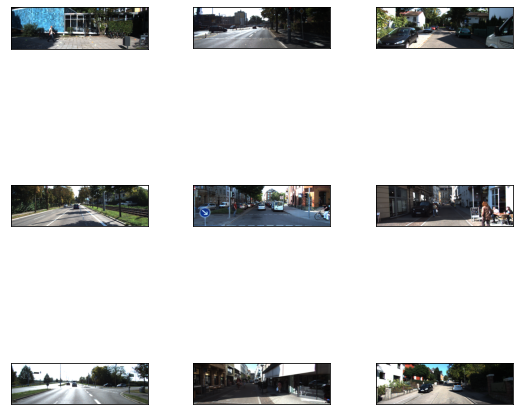

In [3]:
# tfds.show_examples 메소드로 데이터 샘플 확인

fig = tfds.show_examples(ds_train, ds_info)

In [4]:
# ds_info 메소드로 데이터셋 정보 확인

ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/ssac29/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
         

<br>

### 데이터셋에서 이미지, 라벨 추출 <br><br>

tf.data.Dataset 데이터셋에서, <br>

1. take() 메소드로 데이터셋 불러오기 <br>
2. 딕셔너리의 키 값 'image', 'objects' 를 이용해, 이미지와 라벨 데이터 불러오기

<br>

In [5]:
# tf.data.Datset 데이터셋에서 take(1) 메소드로 데이터셋 하나 불러오기 (?)

TakeDataset = ds_train.take(1)
print(TakeDataset)

<TakeDataset shapes: {image: (None, None, 3), image/file_name: (), objects: {alpha: (None,), bbox: (None, 4), dimensions: (None, 3), location: (None, 3), occluded: (None,), rotation_y: (None,), truncated: (None,), type: (None,)}}, types: {image: tf.uint8, image/file_name: tf.string, objects: {alpha: tf.float32, bbox: tf.float32, dimensions: tf.float32, location: tf.float32, occluded: tf.int64, rotation_y: tf.float32, truncated: tf.float32, type: tf.int64}}>


------Example------
['image', 'image/file_name', 'objects'] 

------objects------
{'alpha': <tf.Tensor: shape=(6,), dtype=float32, numpy=array([-0.86, -1.6 , -0.51,  1.44,  1.77,  1.94], dtype=float32)>, 'bbox': <tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[0.0027027 , 0.        , 0.45554054, 0.24836601],
       [0.41256756, 0.8102206 , 0.60175675, 0.8412255 ],
       [0.45089188, 0.8252696 , 0.58402705, 0.96843135],
       [0.45332432, 0.3608987 , 0.53432435, 0.3954902 ],
       [0.4384054 , 0.29299837, 0.5387027 , 0.31436273],
       [0.39505404, 0.16185458, 0.51954055, 0.24050653]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1.5 , 1.78, 3.69],
       [1.72, 0.78, 1.71],
       [1.51, 1.75, 4.45],
       [1.44, 1.64, 3.68],
       [1.87, 0.86, 2.12],
       [1.63, 1.78, 4.54]], dtype=float32)>, 'location': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[ -3.16,   1.68,   3.35],
       [ 10.47,   0.9 ,  18.34],
       [ 16.

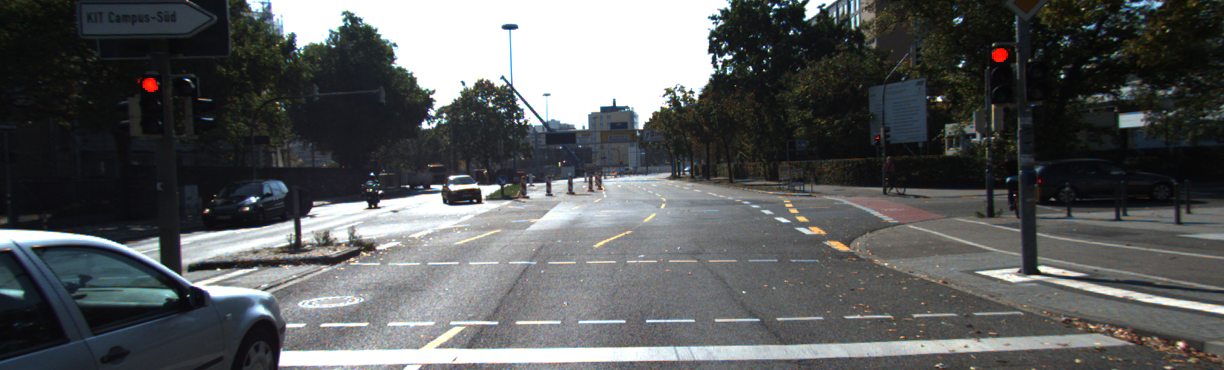

In [6]:
# 불러온 데이터셋에서 이미지와 라벨 추출하여 확인

for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys()), '\n')     # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects, '\n')

# Pillow 라이브러리 Image 클래스 이용하여 numpy array 로 표현된 이미지 데이터 객체 생성
img = Image.fromarray(image.numpy())
img

<br>

### 데이터셋에서 이미지 바운딩 박스 (bbox) 확인 <br><br>

- 텐서플로우 데이터셋의 라벨 ('object') 중 bbox 데이터 불러오기 <br>
    ```objects['bbox']``` <br><br>

- Pillow 라이브러리의 Image 모듈로 이미지 정보 불러오고, <br>
    ImageDraw 모듈로 이미지 데이터 위에 bbox 위치 표시하기 <br><br>
    
    참고. <br>
    [Pillow 라이브러리](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html) <br>
    [ImageDraw 모듈](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html)

<br>

width: 1224  height: 370
(개체 수, bbox 좌표 수) :  (6, 4) 

바운딩 박스 좌표
[  0.   369.   304.   201.45]
[ 991.71  217.35 1029.66  147.35]
[1010.12994  203.17    1185.36     153.90999]
[441.74002 202.27    484.08002 172.29999]
[358.63    207.79001 384.78    170.68   ]
[198.11 223.83 294.38 177.77]

 <PIL.Image.Image image mode=RGB size=1224x370 at 0x7F65A01187D0>


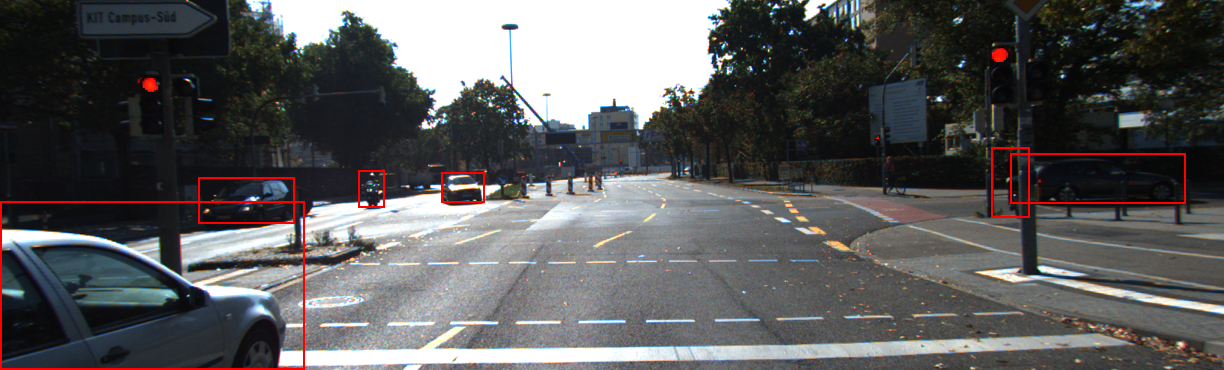

In [7]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해주는 함수 작성

def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
                    # Pillow.Image.size : Pillow 이미지 객체에서 size 정보 가져오기
    print('width:', width, ' height:', height)
    print('(개체 수, bbox 좌표 수) : ', object_bbox.shape, '\n')
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
            # np.stack : 'axis' dimension 따라 입력 array 를 join
    print('바운딩 박스 좌표')
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print('\n', input_image)
    return input_image

# 작성한 visiualize_bbox 함수로 이미지 위에 바운딩 박스 시각화
visualize_bbox(img, objects['bbox'].numpy())

<br>

## RetinaNet <br><br>

[Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002) 논문을 통해 공개된 object detection 모델 <br><br>

모델을 직접 만들어 학습 시키기에는 너무 많은 시간이 소요되기 때문에, <br>
미리 구현된 모델인 Keras RetinaNet 라이브러리를 가져와 커스텀 데이터셋으로 학습시켜 빠르게 사용해 봅시다.

<br>

<br>

### Keras RetinaNet <br><br>


Keras RetinaNet : 케라스 라이브러리로 구현된 RetinaNet 모델 <br><br>


- 텐서플로우 2 버전 지원하는 레포지토리 존재 <br><br>


- 아직 커스텀 데이터셋을 학습하는 방법은 공식문서로 없음 <br>

    Tensorflow Dataset 의 KITTI 데이터셋을 사용하여 Keras RetinaNet 을 학습시키기 위해, <br>
    Keras RetinaNet 라이브러리를 수정해야 합니다 ! <br>
    (Tensorflow Dataset 자료형에 맞지 않기 때문 ?) <br><br>

    더 쉬운 방법. <br>
    Tensorflow Dataset 에 맞게 Keras RetinaNet 모델을 수정하는 것보다, <br>
    범용적 데이터셋 포맷인 CSV 형태로 Keras RetinaNet 모델을 수정하는 것이 더 쉬움 ! <br><br>

참고. <br>
[Keras RetinaNet](https://github.com/fizyr/keras-retinanet)

<br>

<br>

### Keras RetinaNet 사용 : 데이터 포맷 변경 <br><br>


Tensorflow Dataset 의 API 를 사용해 데이터를 추출하고 <br>
추출한 데이터를 포맷팅 하여 CSV 데이터 형태로 한 줄씩 저장 <br><br>


한 라인에 <br>
이미지 파일 위치, 바운딩 박스 위치, 클래스 정보 갖는 CSV 파일 생성하는 코드 작성 <br><br>

데이터 포맷 <br>
```
# 데이터셋 형식
path/to/image.jpg,x1,y1,x2,y2,class_name

# Example
/data/imgs/img_001.jpg,837,346,981,456,cow
/data/imgs/img_002.jpg,215,312,279,391,cat
/data/imgs/img_002.jpg,22,5,89,84,bird
/data/imgs/img_003.jpg,,,,,
```
<br>

CSV 저장 코드
```
df_test = parse_dataset(ds_test, total=ds_info.splits['test'].num_examples)
df_test.to_csv('./kitti_test.csv', sep=',',index = False, header=False)
```
<br>

In [8]:
# Tensorflow Dataset 데이터를 추출하여 CSV 데이터로 변경해주는 함수 작성

import os
data_dir = base_dir + '/data'
img_dir = base_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df



In [9]:
# 학습 데이터셋에 대해, parse_dataset() 함수를 적용하여 dataframe 생성
# 한번 생성한 뒤 주석처리

"""
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)
"""

"\ndf_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)\ndf_train.to_csv(train_csv_path, sep=',',index = False, header=False)\n"

In [10]:
# 평가 데이터셋에 대해, parse_dataset() 함수를 적용하여 dataframe 생성
# 한번 생성한 뒤 주석처리

"""
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)
"""

"\ntest_csv_path = data_dir + '/kitti_test.csv'\n\ndf_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)\ndf_test.to_csv(test_csv_path, sep=',',index = False, header=False)\n"

<br>

### Class mapping <br><br>

데이터셋에서의 class 표현 : 문자열 (string) <br>
모델이 학습하는 class 표현 : 숫자 <br><br>

여러 class 에 대해 각각 index 를 매핑하여 저장하고, <br>
학습 이후 추론(inference) 할 때에도 이를 통해 결과 해석 <br><br>

클래스 매핑 형식 <br>
```
class_name,id

#Example
cow,0
cat,1
bird,2
```

<br>

In [11]:
# 클래스를 문자에서 숫자로 변환하기 위한 클래스 매핑 함수 작성

class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):

    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

<br>

### Keras RetinaNet 사용 : 모델 학습 <br><br>


#### keras-retinanet 을 이용한 학습 방법 <br><br>


- 프로젝트 디렉토리에 Keras RetinaNet 레포지토리 받고, <br>
    레포지토리 사용에 필요한 Keras 라이브러리 설치 <br><br>

    ```
    $ cd ~/aiffel/Going_Deeper/04_Object_Detection/kera-retinanet
    $ git clone https://github.com/fizyr/keras-retinanet.git
    $ cd keras-retinanet && python setup.py build_ext --inplace
    ``` <br><br>

- Keras RetinaNet 레포지토리 받은 디렉토리 내에서 pip 패키지로 keras-retinanet 인스톨 <br><br>

- 아래 스크립트를 참고하셔서 위에서 변환한 데이터셋으로 학습을 시작 <br><br>


#### 모델 학습 <br><br>

환경에 따라 batch_size, worke, epoch 조절 <br>
학습 이미지 크기나 batch_size가 너무 크면 GPU 에서 Out-Of-Memory (OOM) 에러가 날 수 있음 <br>
(8G 메모리도 RetinaNet 훈련에는 부족할 수 있습니다)

<br>

In [12]:
# RetinaNet 훈련이 시작 
# 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 

!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt


Epoch 12/50
195/195 [==============================] - ETA: 0s - loss: 1.5290 - regression_loss: 1.1967 - classification_loss: 0.3324
Epoch 00012: saving model to ./snapshots/resnet50_csv_12.h5
195/195 [==============================] - 66s 338ms/step - loss: 1.5290 - regression_loss: 1.1967 - classification_loss: 0.3324
Epoch 13/50
195/195 [==============================] - ETA: 0s - loss: 1.5140 - regression_loss: 1.1648 - classification_loss: 0.3492
Epoch 00013: saving model to ./snapshots/resnet50_csv_13.h5
195/195 [==============================] - 66s 338ms/step - loss: 1.5140 - regression_loss: 1.1648 - classification_loss: 0.3492
Epoch 14/50
195/195 [==============================] - ETA: 0s - loss: 1.4646 - regression_loss: 1.1414 - classification_loss: 0.3232
Epoch 00014: saving model to ./snapshots/resnet50_csv_14.h5
195/195 [==============================] - 66s 338ms/step - loss: 1.4646 - regression_loss: 1.1414 - classification_loss: 0.3232
Epoch 15/50
195/195 [=========

In [13]:
# 아래 코드를 사용하여, 학습된 모델 추론을 위해 실행할 수 있는 케라스 모델로 변환

!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-27 12:19:36.354056: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 12:19:38.079488: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-27 12:19:38.086649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 12:19:38.087090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-27 12:19:38.087119: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 12:19:38.091786: I tensorflow/stream_executor/platform

<br>

### Keras RetinaNet 사용 : 학습된 모델로 추론 결과 시각화 <br><br>

위에서 변환된 모델 load 하여 추론(inference) 후 시각화 하는 함수를 작성 <br><br>

[추론 테스트를 위한 테스트셋 download](https://aiffelstaticprd.blob.core.windows.net/media/documents/test_set.zip)

<br>

In [ ]:
# 추론에 필요한 클래스 맵 생성



In [28]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


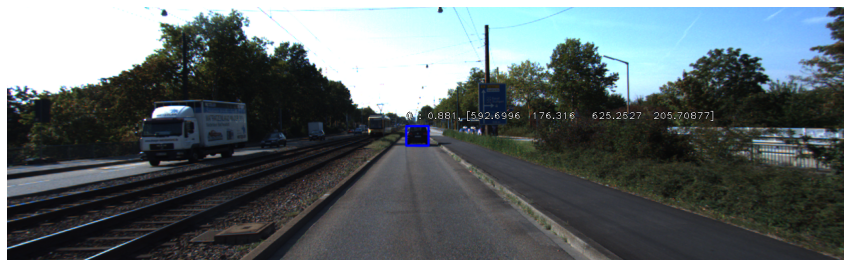

In [92]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    box_list = []
    score_list = []
    label_list = []
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < 0.5:
            break
        # print(box)    # 박스 좌표 확인
        b = box.astype(int)
        draw_box(draw, b, color=color_map[label])

        box_list.append(box)
        score_list.append(score)
        label_list.append(label)

        caption = "{} : {:.3f}, {}".format(label, score, box)
        draw_caption(draw, b, caption)

    # display images
    if  visualize:
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
    else:
        return box_list, score_list, label_list

inference_on_image(model, img_path=img_path)

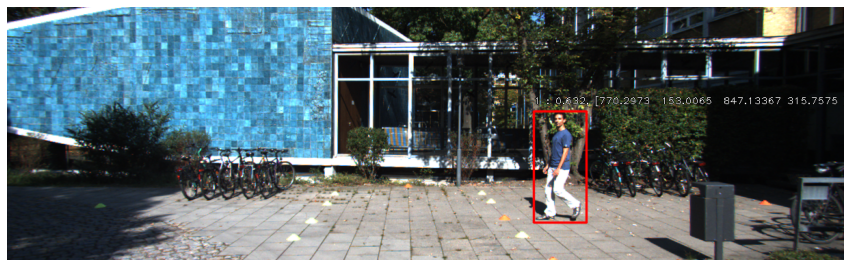

In [93]:
img_path = base_dir + '/test_set/stop_1.png'

inference_on_image(model, img_path=img_path)

<br>

## 학습된 모델 활용 <br><br>


### 자율주행 보조 시스템 만들기 <br><br>


위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 작성

- 입력으로 이미지 경로를 받아옴 <br>

- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환 <br>

- 정지조건 <br>

    1. 사람이 한 명 이상 있는 경우<br>
    
    2. 차량의 크기(width or height)가 300px이상인 경우 <br>

<br>

In [109]:
# 학습된 keras-retinanet 모델을 활용한 자율주행 보조 시스템 수행 함수 작성

import os

# 입력 이미지 경로
test_dir_path = base_dir + '/test_set'

img_path = base_dir + '/test_set/stop_1.png'

# 자율주행 보조 시스템 수행 함수
def self_drive_assist(img_path, size_limit=300):
    
    # 코드 구현
    # print(img_path)
    box_list, score_list, label_list = inference_on_image(model, img_path=img_path, visualize=False)
    # print(box_list)
    # print(label_list)

    for j in range(len(box_list)):

        # 정지조건에 맞으면 return "Stop"
        if box_list[j][2] - box_list[j][0] >= size_limit or label_list[j] == 1:
            return "Stop"

        # 아닌 경우 return "Go"
        else:
            return "Go"

# 테스트 결과
print(self_drive_assist(img_path))

Stop


<br>

### 자율주행 시스템 평가 <br><br>

test_system() 함수를 작성하여 위에서 만든 함수를 평가 <br>
10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가

<br>

In [110]:
# 자율주행 시스템 평가함수 작성
# 100점 만점 기준으로 모델 활용 결과 평가

import os

# 평가 데이터셋으로 자율주행 보조 시스템 함수 평가하는 함수
def test_system(func):
    work_dir = base_dir
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

# 평가 데이터셋에 대한 평가 결과
test_system(self_drive_assist)

90점입니다.
